<a href="https://colab.research.google.com/github/LDSoul/NCUT_project/blob/master/CNN%E6%B8%AC%E8%A9%A6(Keras).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

2. Data preparation


2.1 Load data


5    49
3    48
1    41
4    37
2    37
0    35
Name: label, dtype: int64

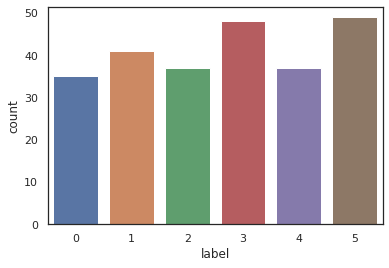

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Y_train = train["label"]

#設置 標籤 列
X_train = train.drop(labels = ["label"],axis = 1)

del train

#繪製圖表
g = sns.countplot(Y_train)

Y_train.value_counts()



2-2檢查空值或空乏值

In [ ]:
X_train.isnull().any().describe()

count     10000
unique        1
top       False
freq      10000
dtype: object

In [ ]:
test.isnull().any().describe()

count     10000
unique        1
top       False
freq      10000
dtype: object

2-3正規化

In [ ]:
#正規化資料
X_train = X_train / 255.0
test = test / 255.0

2-4重組(Reshape)

In [ ]:
#將圖形變成[-1 28 28 1]  28*28
#-1代表不考慮輸入的圖片例子為多少維度
#1是channel的數量 黑白:1 彩色:3
X_train = X_train.values.reshape(-1,100,100,1)
test = test.values.reshape(-1,100,100,1)

2-5 編碼標籤(Label encoding)

In [ ]:
#若是0~9 10個數字 那訂的標籤就是
#ex:2==>[0,0,1,0,0,0,0,0,0,0]
Y_train = to_categorical(Y_train,num_classes = 6)

2-6 (Split training and valdiation set)

In [ ]:
#設置隨機種子2
random_seed = 2
## Split the train and the validation set for the fitting
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size = 0.1,random_state = random_seed)

將訓練資料拆成兩部分
10%用來驗證 90%用來訓練
因此隨機分配火車集不會導致某些標籤在驗證集中過分顯示。 
小心一些不平衡的數據集
簡單的隨機分割可能會導致驗證期間的評估不准確。
為避免這種情況，
可以在train_test_split函數中
使用stratify = True選項（僅適用於> = 0.17 sklearn版本）。

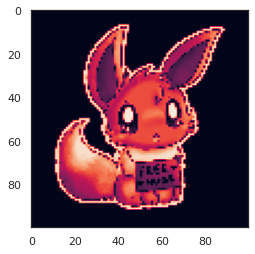

In [ ]:
g = plt.imshow(X_train[9][:,:,0])

CNN

3.1 定義模型

In [ ]:
#使用Keras Sequential API 一開始輸入只需新增一層
model = Sequential()

#建立卷積層(Conv2D層) filter=32
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation = 'relu',input_shape = (100,100,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,kernel_size = (3,3),padding='Same',activation = 'relu'))
model.add(Conv2D(filters=64,kernel_size = (3,3),padding = 'Same' , activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10,activation = "softmax"))

設置優化器

In [ ]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [ ]:
model.compile(optimizer = optimizer,loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 100, 100, 32)      832       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 100, 100, 32)      25632     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 25, 25, 64)       

In [ ]:
#為了使LOSS接近0 使用優化器收斂 學習綠(Lr降低 有效達到損失函數最小值)
lr = ReduceLROnPlateau(monitor = 'val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

epochs = 12
batch_size = 100

3-3 Data augmentation

In [ ]:

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

對於數據擴充，我選擇了：

將一些訓練圖像隨機旋轉10度
隨機放大10％的一些訓練圖像
水平隨機移動圖像寬度的10％
垂直隨機移動圖像高度的10％
我沒有應用vertical_flip或horizo​​ntal_flip，因為它可能導致對對稱數字（例如6和9）進行錯誤分類。

模型準備就緒後，我們就可以擬合訓練數據集

In [ ]:
#Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[lr])

ValueError: ignored

In [ ]:
#X_train,X_val,Y_train,Y_val
score = model.evaluate(X_val,Y_val)

25/25 [==============================] - 0s 18ms/step


In [ ]:
print('loss:',score[0])
print('acc:',score[1])

loss: 2.140167474746704
acc: 0.1599999964237213


4-2混淆矩陣(Confusion matrix)
對於查看模型的缺陷很有幫助

In [ ]:

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

NameError: ignored